In [1]:
%config Completer.use_jedi = False
# Import Python 3's print function and division
from __future__ import print_function, division

#Loading data
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import MinMaxScaler
#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

#plots
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from collections import OrderedDict

cmaps = OrderedDict()

#metrics
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.metrics import recall_score,precision_score, cohen_kappa_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, \
            classification_report, recall_score, precision_recall_curve

#cross validations
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr

# Define random state
random_state = 2019
np.random.seed(random_state)
warnings.filterwarnings('ignore')

#librerias de sistema
import os



# latex parameter
font = {
    'family': 'serif', 
    'serif': ['Computer Modern Roman'],
    'weight' : 'regular',
    'size'   : 8
    }

plt.rc('font', **font)

In [2]:
#slope --    CTE
#soil type---CTE
#land use ---- Variable 
#Bearing capacity .. simulate scenarios for 2007 starting from 1999 bearing capacity map

#Hazard level 2001 for training and 2007 for validation

<img src="D:/Proyectos_GitHub/PISCO_Peligro/img/idea_1.png">

In [3]:
#Bajo 1
#Medio 2
#Alto 3
#Muy Alto 4

#### TIPOS de Suel

In [4]:
def show_field(field1,field2):
    tar_names=['vacio','Medio','Alto','Muy Alto']
    combined_data = np.array([field1,field2])
    #Get the min and max of all your data
    _min, _max = np.amin(combined_data), np.amax(combined_data)

    fig = plt.figure(figsize=(15,20))
    ax = fig.add_subplot(1, 2, 1)
    #Add the vmin and vmax arguments to set the color scale
    ax.imshow(field1,cmap='tab20b', vmin = _min, vmax = _max)
    #ax.set_adjustable('box-forced')
    ax.autoscale(False)
    ax2 = fig.add_subplot(1, 2, 2)
    #ax2.set_adjustable('box-forced')
    #Add the vmin and vmax arguments to set the color scale
    im=ax2.imshow(field2,cmap='tab20b', vmin = _min, vmax = _max)
    ax2.autoscale(False)
    
    values=np.unique(field2)
    colors = [ im.cmap(im.norm(value)) for value in np.unique(field2)]
    #patches = [ mpatches.Patch(color=colors[i], label="Bioma {l}".format(l=values[i]) ) for i in range(len(values)) ]
    patches = [ mpatches.Patch(color=colors[i], label=tar_names[i] ) for i in range(len(values)) ]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. ,title='Hazard level',fontsize=12,title_fontsize=15)
    
    plt.show()
    pass

In [5]:
class Create_ensemble(object):
    def __init__(self, n_splits, base_models):
        self.n_splits = n_splits
        self.base_models = base_models
        self.metriks={}
        self.RE=[]
        self.F1=[]
        self.PRE=[]#

    def predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)
        no_class = len(np.unique(y))

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, 
                                     random_state = random_state).split(X, y))

        train_proba = np.zeros((X.shape[0], no_class))
        test_proba = np.zeros((T.shape[0], no_class))
        
        train_pred = np.zeros((X.shape[0], len(self.base_models)))
        test_pred = np.zeros((T.shape[0], len(self.base_models)* self.n_splits))
        f1_scores = np.zeros((len(self.base_models), self.n_splits))
        recall_scores = np.zeros((len(self.base_models), self.n_splits))
        
        test_col = 0
        for i, clf in enumerate(self.base_models):
            
            for j, (train_idx, valid_idx) in enumerate(folds):
                
                X_train = X[train_idx]
                Y_train = y[train_idx]
                X_valid = X[valid_idx]
                Y_valid = y[valid_idx]
                
                clf.fit(X_train, Y_train)
                
                valid_pred = clf.predict(X_valid)
                recall  = recall_score(Y_valid, valid_pred, average='macro')
                precision=precision_score(Y_valid,valid_pred,average='macro')#
                f1 = f1_score(Y_valid, valid_pred, average='macro')
                
                recall_scores[i][j] = recall
                f1_scores[i][j] = f1
                
                train_pred[valid_idx, i] = valid_pred
                test_pred[:, test_col] = clf.predict(T)
                test_col += 1
                
                ## Probabilities
                valid_proba = clf.predict_proba(X_valid)
                train_proba[valid_idx, :] = valid_proba
                test_proba  += clf.predict_proba(T)
                
                self.RE.append(recall)
                self.F1.append(f1)
                self.PRE.append(precision)#
                print( "Model- {} and CV- {} recall: {}, precision: {}, f1_score: {}".format(i, j, recall,precision, f1))
                
            test_proba /= self.n_splits
            self.metriks['recall']=self.RE
            self.metriks['f1']=self.F1
            self.metriks['precision']=self.PRE#
            
        return train_proba, test_proba, train_pred, test_pred,self.metriks

# Loading Data and splitting it into 80% training and 20% test data

In [6]:
data=pd.read_csv('D:/Proyectos_GitHub/PISCO_Peligro/data/CSV/data.csv')
features=data.iloc[:,0:4]
target=data.loc[:,'hazard_value']
xtrain, xtest, ytrain, ytest = train_test_split(features, target, test_size=0.20, random_state=42)

# Best parameters grid search for RF

In [7]:
cv = StratifiedKFold(n_splits = 3, shuffle=True, random_state = random_state)

rdf = RandomForestClassifier(random_state = random_state) 
scoring = {'Recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)
          }

params = {'max_depth': [5, 10, 20,30], 
              'n_estimators' : [200,250,300,350,400,450,500]
             }
grid_clf= RandomizedSearchCV(estimator = rdf, param_distributions = params, n_iter = 50, cv = cv, verbose=4, n_jobs = -1)
#grid_clf = GridSearchCV(estimator = rdf, param_grid = params, cv = cv, n_jobs=-1, verbose=4)
grid_clf.fit(xtrain, ytrain)

print(grid_clf.best_estimator_)
print(grid_clf.best_params_)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  59 out of  84 | elapsed:    8.0s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  81 out of  84 | elapsed:   10.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:   10.8s finished


RandomForestClassifier(max_depth=10, n_estimators=300, random_state=2019)
{'n_estimators': 300, 'max_depth': 10}


# CROSS VALIDATION

In [8]:
rdf = RandomForestClassifier(bootstrap=True, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False,
            random_state=random_state,
            verbose=0, warm_start=False)

base_models = [rdf]
n_splits = 5
rf_stack = Create_ensemble(n_splits = n_splits, base_models = base_models)     
train_proba, test_proba, train_pred, test_pred,indi_rf = rf_stack.predict(xtrain, ytrain, xtest)

Model- 0 and CV- 0 recall: 0.8660506418864165, precision: 0.8917339174886542, f1_score: 0.8780084837732929
Model- 0 and CV- 1 recall: 0.8475956120853704, precision: 0.8915816865468557, f1_score: 0.8670961606290025
Model- 0 and CV- 2 recall: 0.8410807956587099, precision: 0.8834050508652274, f1_score: 0.8597914169948068
Model- 0 and CV- 3 recall: 0.8382900868726901, precision: 0.8813052919586063, f1_score: 0.8573111318514811
Model- 0 and CV- 4 recall: 0.8659377690558859, precision: 0.8965436129493572, f1_score: 0.8801110403879441


In [9]:
print('1. The F-1 score of the model {}\n'.format(f1_score(ytrain, train_pred, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(ytrain, train_pred, average='macro')))
print('3. Classification report \n {} \n'.format(classification_report(ytrain, train_pred)))
print('4. Confusion matrix \n {} \n'.format(confusion_matrix(ytrain, train_pred)))

1. The F-1 score of the model 0.8685927282884243

2. The recall score of the model 0.8517397598099362

3. Classification report 
               precision    recall  f1-score   support

           2       0.97      0.99      0.98      7851
           3       0.98      0.97      0.98      8890
           4       0.71      0.60      0.65       307

    accuracy                           0.97     17048
   macro avg       0.89      0.85      0.87     17048
weighted avg       0.97      0.97      0.97     17048
 

4. Confusion matrix 
 [[7735  108    8]
 [ 167 8658   65]
 [  34   90  183]] 



# Predicting Hazard Maps 

In [10]:
def predictions(x,model,target):
    result=model.predict(x.dropna())
    target[list(x.dropna().index)]=result 
    return target

Loading rasters

In [11]:
# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()
explanatory_rasters = os.listdir("D:/Proyectos_GitHub/PISCO_Peligro/data/rasters/input/")
# Read in our predictors into img_ds and ROI is the current biome configuration

img_ds=[gdal.Open("D:/Proyectos_GitHub/PISCO_Peligro/data/rasters/input/"+pred, gdal.GA_ReadOnly) for pred in explanatory_rasters]   

roi_ds = gdal.Open('D:/Proyectos_GitHub/PISCO_Peligro/data/rasters/target/hazard.tif', gdal.GA_ReadOnly)

#saving the image as arrays
img = [img_ds[i].GetRasterBand(1).ReadAsArray() for i in range(len(img_ds))]
    
roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

In [12]:
n,m=img[1].shape
target=-1*np.ones((n*m))
predictores=[]
for i in range(len(img)):
    predictores.append(img[i].reshape(n*m))


#las columnas son los datos de los rasters
covariable=pd.DataFrame(np.concatenate([predictores])).transpose()
#nombre de las columnas
covariable.columns=[explanatory_rasters[i].split('.')[0] for i in range(len(explanatory_rasters))]
#cleanning negative values in predictors
covariable[covariable<-100]=np.nan
covariable.columns=['capacity_value','dem_value','slope_value','soil_value']

In [13]:
#Training the model with the 80% data
rdf.fit(xtrain,ytrain)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=300, n_jobs=-1, random_state=2019)

In [14]:
result=predictions(covariable,rdf,target).reshape(n,m)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


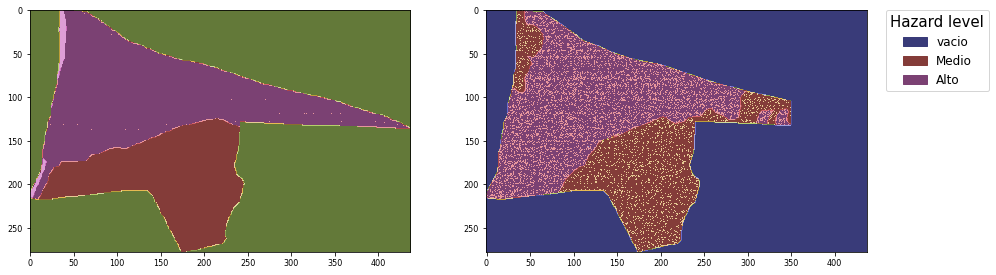

In [15]:
show_field(roi,result)

# feature of importance

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


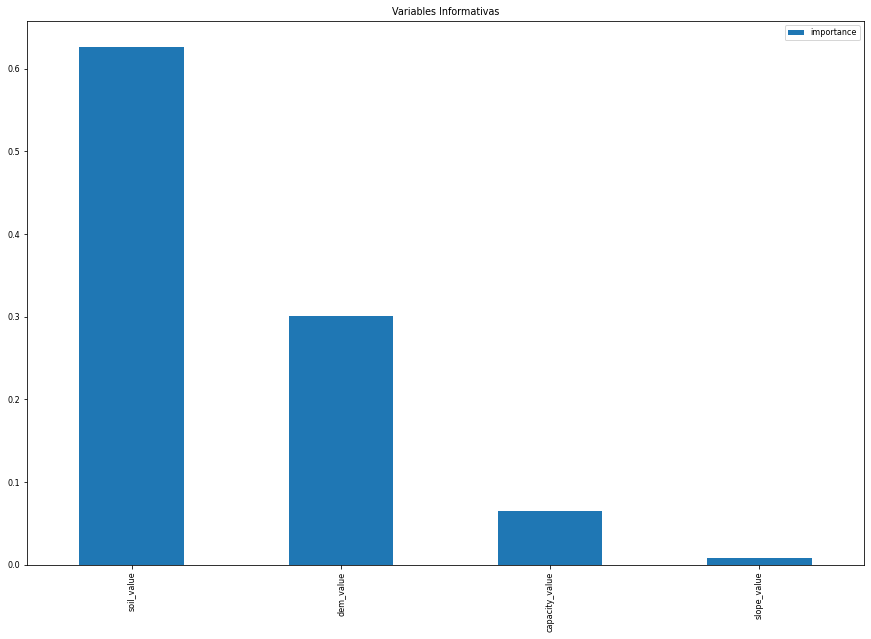

In [17]:
feature_imporanteces=pd.DataFrame(rdf.feature_importances_,index=covariable.columns,columns=['importance']).sort_values('importance',ascending=False)
feature_imporanteces.plot.bar(figsize=(15,10))
plt.title('Variables Informativas')
plt.show()